Shape of pre_train: (2000, 500)
Shape of pre_train: (2000,)
Shape of pre_train: (600, 500)
Shape of pre_train: (600,)
[0. 0. 0. ... 0. 1. 1.]
    Lambda  Selected Features  Train Misclassification Error  \
0  0.00004                500                         0.2585   
1  0.00735                302                         0.2715   
2  0.01721                100                         0.3280   
3  0.02422                 31                         0.3630   
4  0.02980                  8                         0.3860   

   Test Misclassification Error  
0                      0.426667  
1                      0.428333  
2                      0.435000  
3                      0.423333  
4                      0.395000  


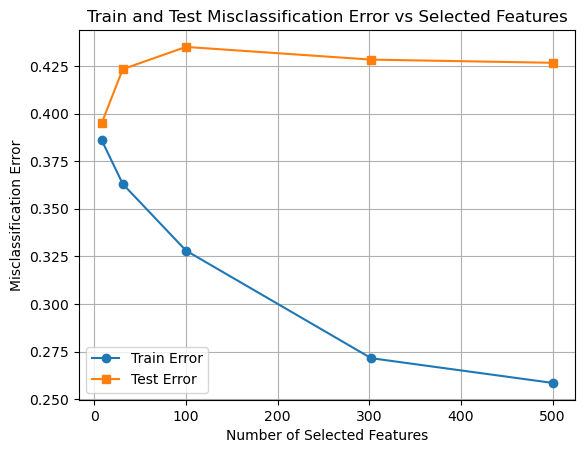

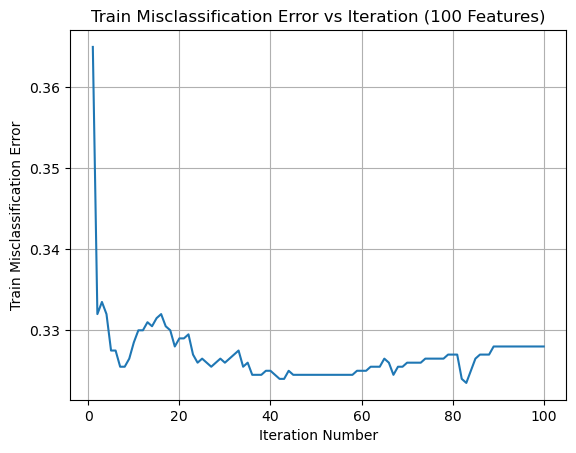

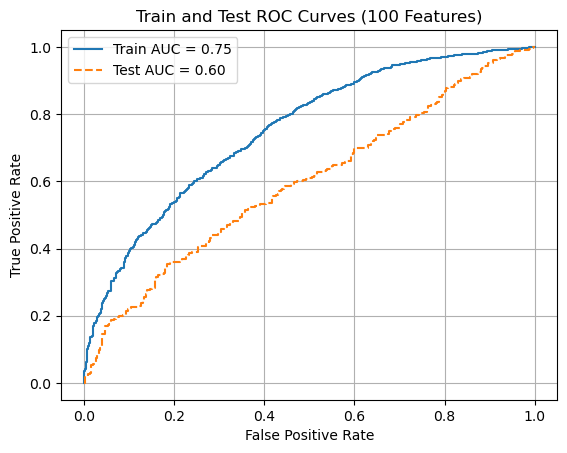

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, roc_curve, auc
import zipfile
import os

zip_path = r"C:\Users\basak\Documents\MS-Data Science\Spring-2025\Python\ML HW\dataset\MADELON.zip"
extract_dir = r"C:\Users\basak\Documents\MS-Data Science\Spring-2025\Python\ML HW\dataset\MADELON_ext"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

dtrain_path = os.path.join(extract_dir, "madelon_train.data")
ltrain_path = os.path.join(extract_dir, "madelon_train.labels")
dtest_path = os.path.join(extract_dir, "madelon_valid.data")
ltest_path = os.path.join(extract_dir, "madelon_valid.labels")

X = np.loadtxt(dtrain_path)
y = np.loadtxt(ltrain_path)
X_test = np.loadtxt(dtest_path)
y_test = np.loadtxt(ltest_path)

print(f"Shape of pre_train: {X.shape}")
print(f"Shape of pre_train: {y.shape}")
print(f"Shape of pre_train: {X_test.shape}")
print(f"Shape of pre_train: {y_test.shape}")

def convert_labels(y):
    return np.where(y == -1, 0, y)

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
std[std == 0] = 1 
y = convert_labels(y)
y_test = convert_labels(y_test)
X = (X - mean) / std
X_test = (X_test - mean) / std 
print(y)

def threshold_operator(x, lambd):
    return np.where(np.abs(x) > lambd, x, 0)

def tisp_classifier(X, y, max_iter=100, lambd_values=[0.00004, 0.00735, 0.01721, 0.02422, 0.0298]):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)  # Initialize weights to 0
    learning_rate = 1 / n_samples

    feature_counts = {}
    misclassification_errors = {}
    test_errors = {}
    all_weights = {}
    all_errors = {}

    for lambd in lambd_values:
        w = np.zeros(n_features)  # Reset weights for each lambda
        errors = []
        for _ in range(max_iter):
            gradient = X.T @ (y - 1 / (1 + np.exp(-X @ w)))
            w = threshold_operator(w + learning_rate * gradient, lambd)
            predictions = (1 / (1 + np.exp(-X @ w))) >= 0.5
            errors.append(1 - accuracy_score(y, predictions))
        
    
        selected_features = np.sum(w != 0)
        feature_counts[lambd] = selected_features
        misclassification_errors[lambd] = errors[-1]
        
       
        test_predictions = (1 / (1 + np.exp(-X_test @ w))) >= 0.5
        test_errors[lambd] = 1 - accuracy_score(y_test, test_predictions)

        all_weights[lambd] = w
        all_errors[lambd] = errors
    
    return feature_counts, misclassification_errors, test_errors, all_weights, all_errors

if __name__ == "__main__":

    lambd_values = [0.00004, 0.00735, 0.01721, 0.02422, 0.0298]  # Tune these for desired counts

   
    feature_counts, misclassification_errors, test_errors, all_weights, all_errors = tisp_classifier(X, y, max_iter=100, lambd_values=lambd_values)
    
    results_df = pd.DataFrame({
        'Lambda': list(feature_counts.keys()),
        'Selected Features': list(feature_counts.values()),
        'Train Misclassification Error': list(misclassification_errors.values()),
        'Test Misclassification Error': list(test_errors.values())
    })
    print(results_df)
    
    plt.plot(feature_counts.values(), misclassification_errors.values(), marker='o', label='Train Error')
    plt.plot(feature_counts.values(), test_errors.values(), marker='s', label='Test Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Misclassification Error')
    plt.title('Train and Test Misclassification Error vs Selected Features')
    plt.legend()
    plt.grid()
    plt.show()
    
    lambda_100 = 0.017210
    final_weights = all_weights[lambda_100]
    errors = all_errors[lambda_100]
    
    plt.plot(range(1, len(errors) + 1), errors)
    plt.xlabel('Iteration Number')
    plt.ylabel('Train Misclassification Error')
    plt.title('Train Misclassification Error vs Iteration (100 Features)')
    plt.grid()
    plt.show()
    
    train_scores = 1 / (1 + np.exp(-X @ final_weights))
    test_scores = 1 / (1 + np.exp(-X_test @ final_weights))
        
    fpr_train, tpr_train, _ = roc_curve(y, train_scores)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)
    
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc(fpr_train, tpr_train):.2f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc(fpr_test, tpr_test):.2f}', linestyle='dashed')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Train and Test ROC Curves (100 Features)')
    plt.legend()
    plt.grid()
    plt.show()
